# Data Analysis and Visualisation &mdash; Lab 02 + 03

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from setuptools.command.rotate import rotate

plt.style.use("ggplot")
plt.rcParams.update({
    "font.size": 12,
})

## Problem 1

### Loading data

In [10]:
statcounter_ww = pd.read_csv("../data/linux-adoption/StatCounter_Worldwide.csv", parse_dates=["Date"])
statcounter_vn = pd.read_csv("../data/linux-adoption/StatCounter_Viet+Nam.csv", parse_dates=["Date"])

In [19]:
steam_hw_survey = pd.read_csv("../data/linux-adoption/Steam+HW+Survey_Platform+Versions.csv", parse_dates=["date"])

In [13]:
distrowatch_phr = pd.read_csv("../data/linux-adoption/DistroWatch_HPD.csv")

### Preprocessing

In [20]:
shs_linux = steam_hw_survey[steam_hw_survey["platform"] == "linux"]

shs_linux.tail()

,date,platform,category,name,change,percentage
647,2025-10-01,linux,Linux Version,Linux Mint 22.2 64 bit,0.0665,0.0665
648,2025-10-01,linux,Linux Version,Other,-0.0428,0.1804
649,2025-10-01,linux,Linux Version,Pop!_OS 22.04 LTS 64 bit,-0.0004,0.0193
650,2025-10-01,linux,Linux Version,Ubuntu 24.04.3 LTS 64 bit,0.0370,0.0370
651,2025-10-01,linux,Linux Version,Ubuntu Core 22 64 bit,0.0055,0.0455


### Plots

#### Market Share Lineplot

**Explanation:**

Visualize the evolution of desktop OS market share over time (Jan 2023 – Oct 2025) to compare trends between Windows, Linux, macOS, and others.

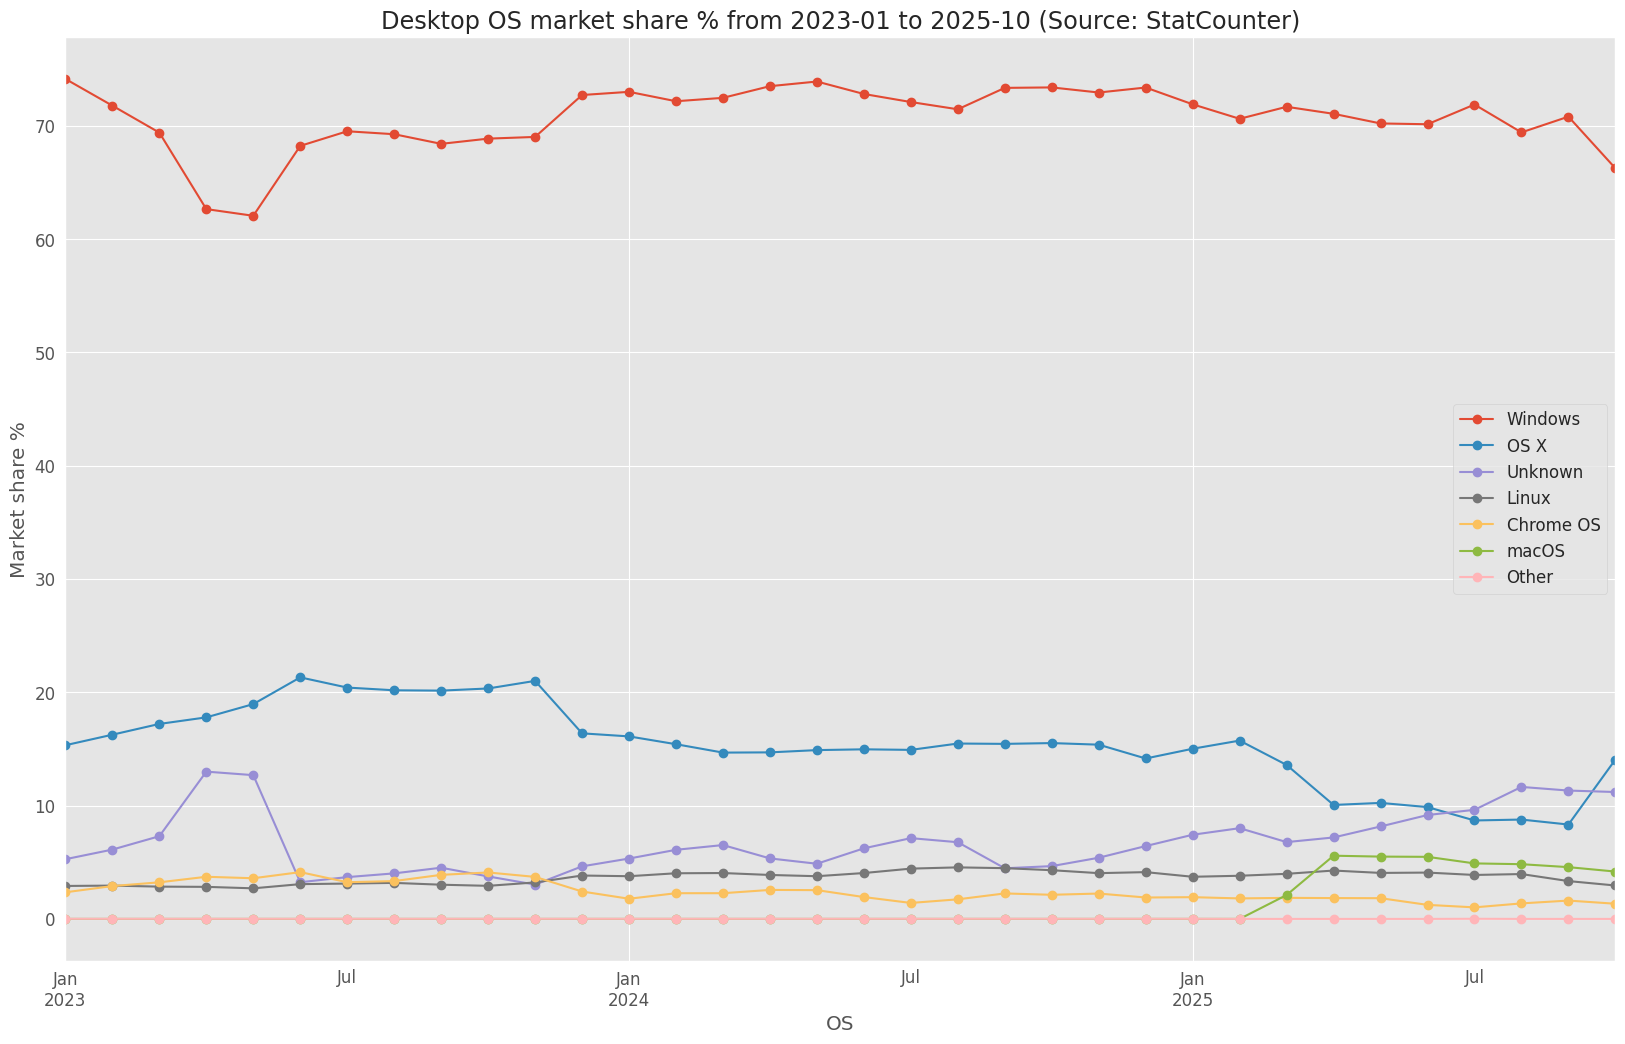

In [11]:
statcounter_ww.plot.line(x="Date", marker="o", figsize=(20, 12))

plt.title("Desktop OS market share % from 2023-01 to 2025-10 (Source: StatCounter)")

plt.xlabel("OS")
plt.ylabel("Market share %")

plt.show()

**Summary:**

* Windows consistently dominates above 60% globally
* Linux shows a slow but steady rise from ~3% to ~4%
* macOS gradually replaces OS X, reflecting Apple's OS transition

Overall, Windows still leads, Linux adoption is growing slowly, and macOS is gradually increasing its share.

#### Steam Linux Piechart

**Explanation:**

A pie chart visualizes the market share percentage of various Linux distributions, as recorded by the Steam Hardware Survey on October 1, 2025. The chart is useful for illustrating the distribution of market share across different Linux distros used by gamers.

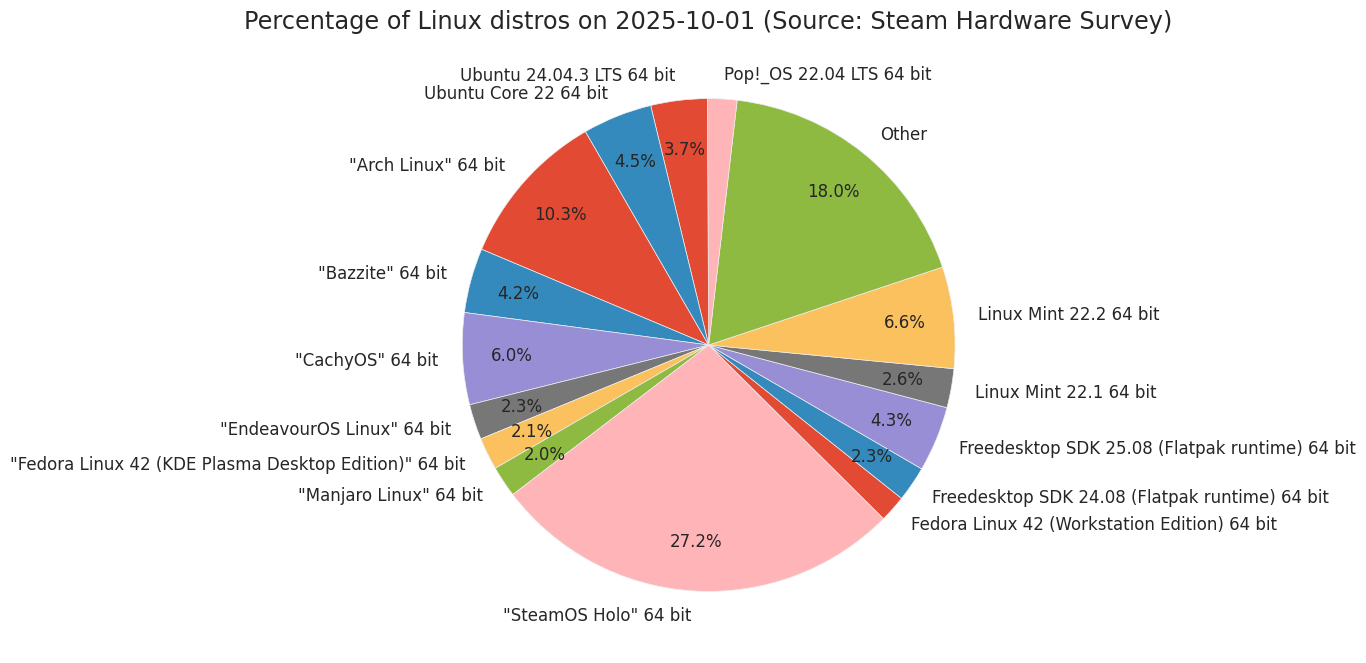

In [68]:
shs_linux[shs_linux["date"] == "2025-10-01"].set_index("name").plot.pie(
    y="percentage",
    autopct=lambda pct: f"{pct:.1f}%" if pct > 2 else "",
    figsize=(8, 8),
    startangle=120,
    pctdistance=0.8,
)

plt.title("Percentage of Linux distros on 2025-10-01 (Source: Steam Hardware Survey)")

plt.legend().remove()
plt.ylabel("")

plt.show()

**Summary:**

* SteamOS Holo leads at 27.2%, reflecting Steam Deck popularity.
* Arch Linux and Arch-based distros (CachyOS, Manjaro, EndeavourOS) collectively make up ~20%.
* Linux Mint and Fedora (including Bazzite) contribute ~10%, showing user-friendly distros remain popular.

Overall, a small number of distros dominate the Linux gaming ecosystem, while others have insignificant shares.

#### DistroWatch Barchart

**Explanation:**

Visualize the popularity of the top 50 Linux distributions by page hits per day across different month ranges to highlight consistent and trending distros.

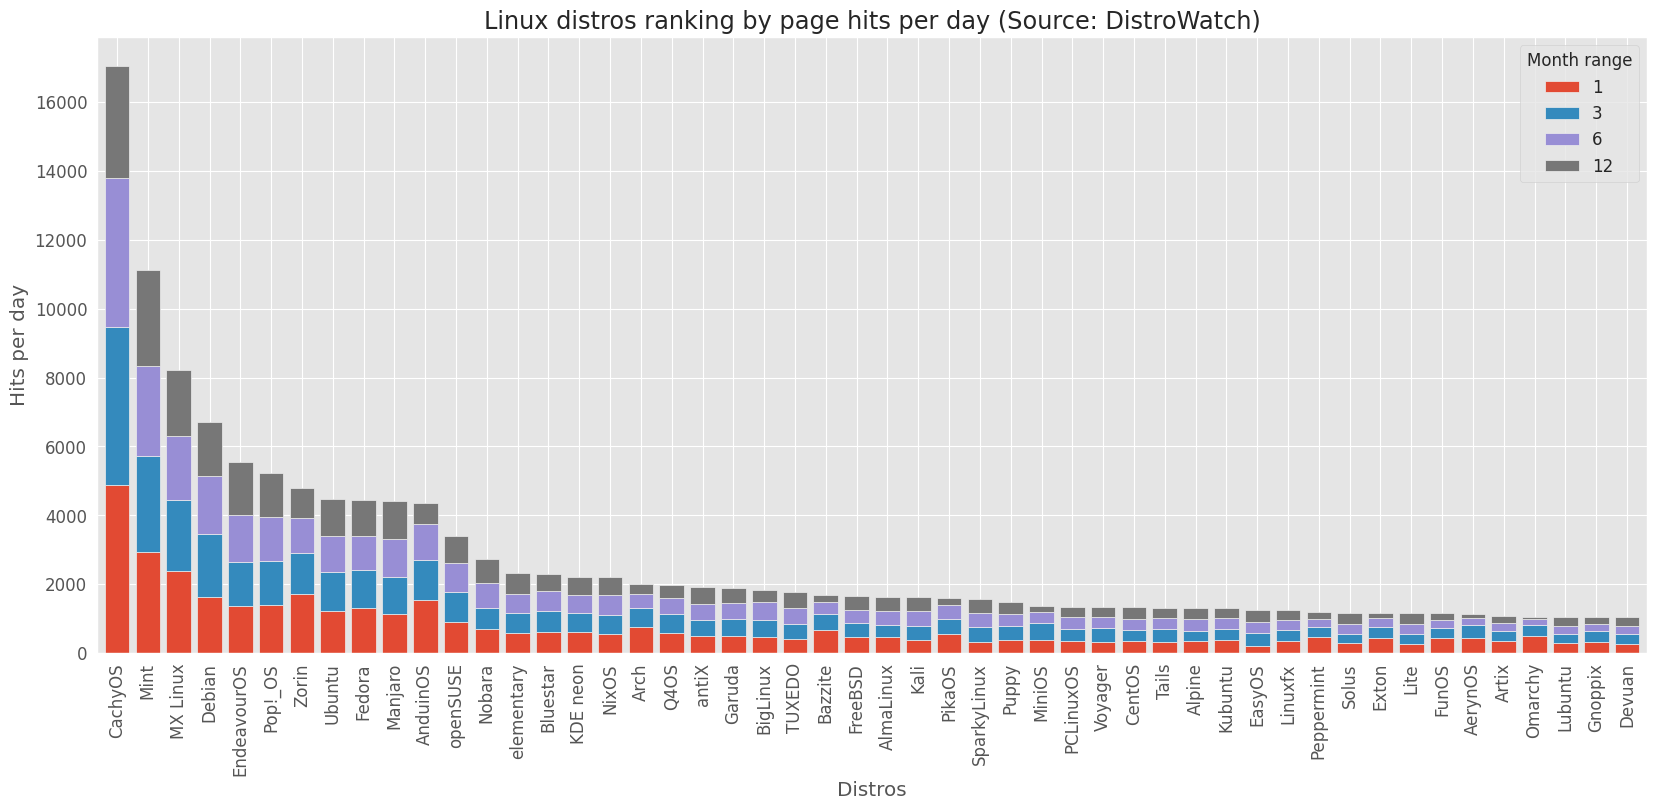

In [14]:
distrowatch_phr \
    .pivot_table(
        index="distro",
        columns="month_range",
        values="hits_per_day",
        aggfunc="sum",
    ).reset_index() \
    .assign(avg_hpd=lambda d: d.drop(columns="distro").mean(axis=1)) \
    .sort_values("avg_hpd", ascending=False).drop(columns="avg_hpd").set_index("distro").head(50) \
    .plot.bar(stacked=True, width=0.8, figsize=(20, 8))

plt.title("Linux distros ranking by page hits per day (Source: DistroWatch)")

plt.xlabel("Distros")
plt.ylabel("Hits per day")

plt.legend(title="Month range")

plt.show()

**Summary:**

* CachyOS consistently ranks #1 across all month ranges.
* User-friendly distros (Mint, Ubuntu, Fedora) typically appear in the top 10.
* Arch-based derivatives (CachyOS, EndeavourOS, Manjaro) are more popular than base Arch Linux.

### Conclusion

* Windows remains dominant on desktops, but Linux shows slow, steady growth both globally and in gaming.
* Among Linux users, a few distros dominate: SteamOS for gaming, CachyOS and Arch-based distros for tech-savvy users, and Mint/Fedora for beginners.

Overall, Linux adoption is niche but steadily rising, with popularity split between user-friendly distributions and enthusiast-focused Arch variants.

## Problem 2

### Loading data

In [4]:
coffee_chains = ["Highlands+Coffee", "Phuc+Long+Coffee", "Starbucks"]
cities = ["Hanoi", "Ho+Chi+Minh+City"]

dfs = {}

for chain in coffee_chains:
    for city in cities:
        key = f"{chain}_{city}"
        path = f"../data/coffee-chains/{chain}_{city}.csv"

        df = pd.read_csv(path)

        group_cols = [col for col in df.columns if col != "info"]
        df = df.groupby(group_cols, as_index=False).first()

        dfs[key] = df

### Plots

#### Reviews Histogram

**Explanation:**

Visualize the distribution of store review counts for each coffee chain in Ho Chi Minh city, highlighting mean and median to compare engagement levels.

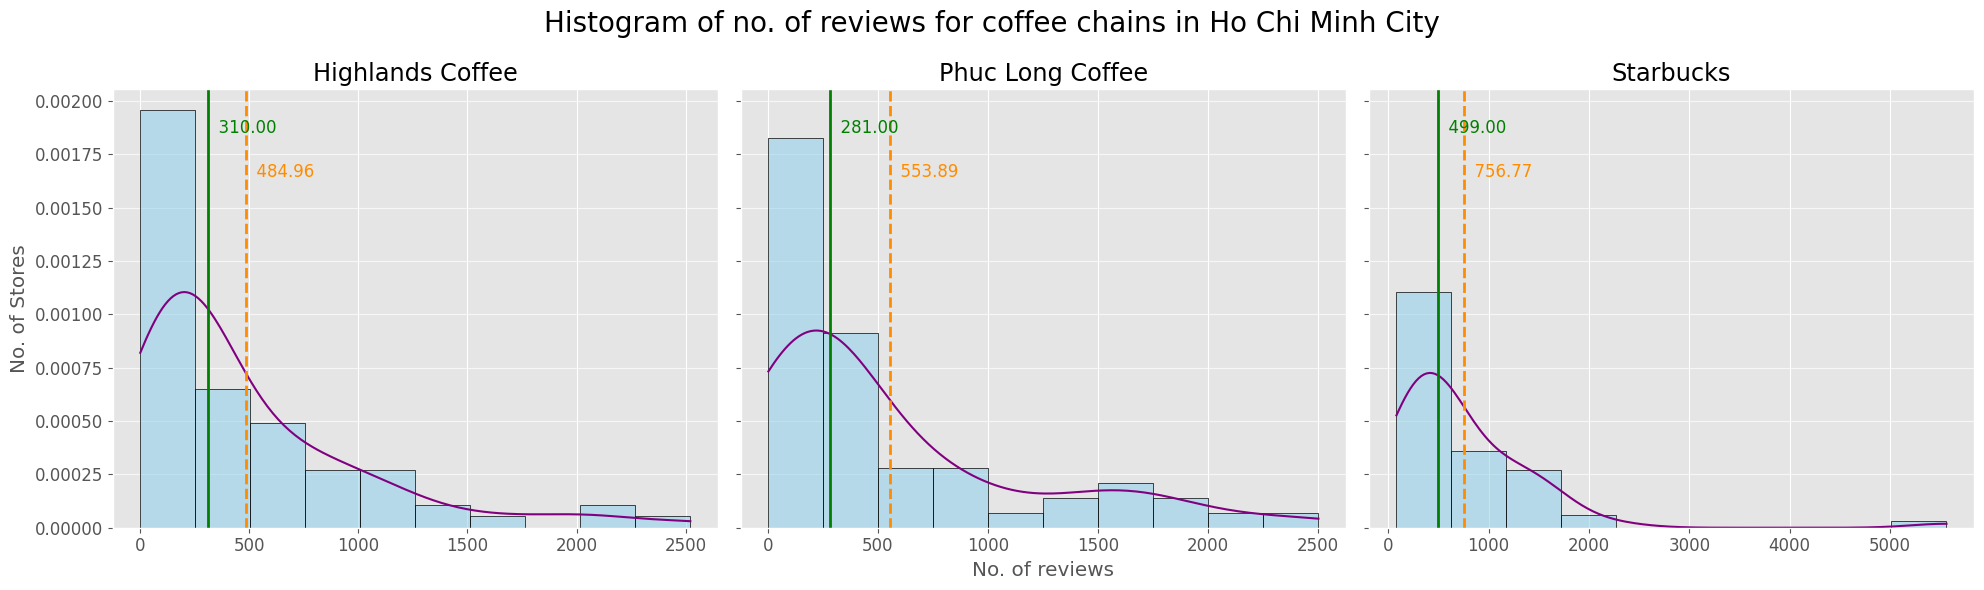

In [72]:
city = "Ho+Chi+Minh+City"

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for i, chain in enumerate(coffee_chains):
    df = dfs[f"{chain}_{city}"]

    num_of_reviews_mean = df["num_of_reviews"].mean()
    num_of_reviews_median = df["num_of_reviews"].median()

    sns.histplot(df["num_of_reviews"], bins=10, kde=True, stat="density", color="skyblue", edgecolor="black", ax=axes[i])

    axes[i].axvline(num_of_reviews_mean, color="darkorange", linestyle="dashed", linewidth=2)
    axes[i].text(num_of_reviews_mean, axes[i].get_ylim()[1] * 0.8, f"  {num_of_reviews_mean:.2f}", color="darkorange")

    axes[i].axvline(num_of_reviews_median, color="green",  linewidth=2)
    axes[i].text(num_of_reviews_median, axes[i].get_ylim()[1] * 0.9, f"  {num_of_reviews_median:.2f}", color="green")

    axes[i].grid(axis="y", alpha=0.7)
    axes[i].lines[0].set_color("purple")

    axes[i].set_title(chain.replace("+", " "))

    axes[i].set_xlabel("No. of reviews" if i == 1 else "")
    if i == 0:
        axes[i].set_ylabel("No. of Stores")

fig.suptitle("Histogram of no. of reviews for coffee chains in Ho Chi Minh City", fontsize=20)
plt.tight_layout()

plt.show()

**Summary:**

* Distributions roughly bell-shaped, but heavy right-skew suggests log-normal behavior.
* Starbucks stores show higher median reviews at ~500, indicating stronger user engagement.

Insights reflect brand positioning: Starbucks as luxury, Highlands and Phuc Long more moderate.

#### Rating Boxenplot

**Explanation:**

Compare the distribution of store ratings for each coffee chain using a horizontal boxen plot to highlight variability and quartiles.

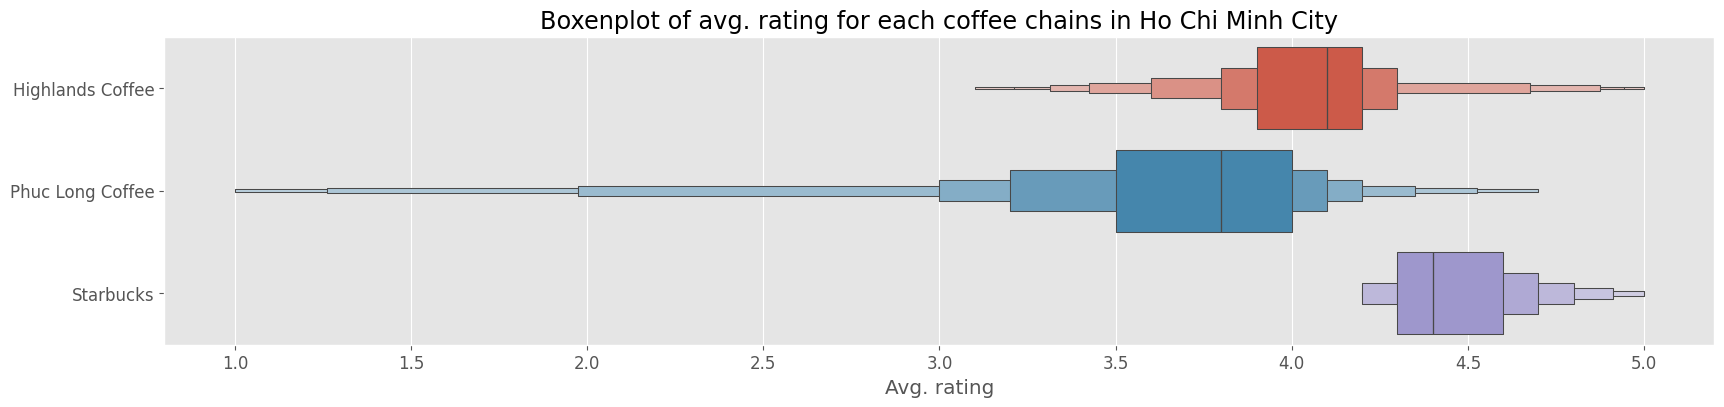

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

city = "Ho+Chi+Minh+City"

box_df = []
for chain in coffee_chains:
    key = f"{chain}_{city}"

    box_df.append(dfs[key].copy())
    box_df[-1]["chain"] = chain.replace("+", " ")

box_df = pd.concat(box_df).melt(
    id_vars=["chain"],
    value_vars=["avg_rating"],
    value_name="Avg. rating",
)

plt.figure(figsize=(20, 4))

sns.boxenplot(
    data=box_df,
    x="Avg. rating", y="chain", hue="chain",
    orient="h", k_depth="full",
)

plt.title("Boxenplot of avg. rating for each coffee chains in Ho Chi Minh City")

plt.ylabel("")

plt.show()

**Summary:**

* Starbucks consistently scores 4.2&ndash;5.0, reflecting its luxury positioning and high customer satisfaction.
* Phuc Long ranges from 1.0&ndash;4.6, offering more products at lower prices, which results in more varied ratings.
* Highlands sits in the middle with ratings around 3.8&ndash;4.2, balancing moderate pricing and steady customer satisfaction.

#### Coffee Chain Folium

**Explanation:**

Visualizes coffee chain locations and their relative popularity in Ho Chi Minh City. Circle size represents the number of reviews for each store, while color distinguishes the chain; Highlights both geographic distribution and customer engagement at a glance, showing clustering in central districts and relative brand performance.

In [5]:
import folium
from folium import CircleMarker

colour_palettes = {
    "Highlands+Coffee": "#c45a32",
    "Starbucks": "#00b57d",
    "Phuc+Long+Coffee": "#7e57c2",
}

city = "Ho+Chi+Minh+City"

m = folium.Map(
    location=[10.7769, 106.7009],
    zoom_start=12,
    tiles="CartoDB positron",
)

for chain in coffee_chains:
    chain_df = dfs[f"{chain}_{city}"]
    for _, store in chain_df.iterrows():
        colour = colour_palettes[chain]
        CircleMarker(
            location=[store["lat"], store["long"]],
            radius=np.clip(store["num_of_reviews"] / 50, 4, 50),
            weight=1, color=colour, opacity=0.4,
            fill=True, fill_color=colour, fill_opacity=0.2,
            popup=store["name"],
        ).add_to(m)

m

**Summary:**

All three chains cluster in Ho Chi Minh City’s central districts, the commercial and tourist hub.

* Starbucks dominates the core areas with many high-review stores, reflecting its premium, high-engagement positioning.
* Phuc Long spreads more broadly across central and nearby districts, showing consistent popularity with moderate-to-large reviews.
* Highlands has a wider city coverage including outskirts, but generally smaller review counts, suggesting broader but less concentrated engagement.

Overall, the map reinforces that store density and customer engagement peak in high-traffic central zones.

#### Services Wordcloud

**Explanation:**

Visualizes the most frequently mentioned features and services across all coffee chains. Larger words indicate higher frequency, showing which amenities are emphasized in store descriptions and likely valued by customers.

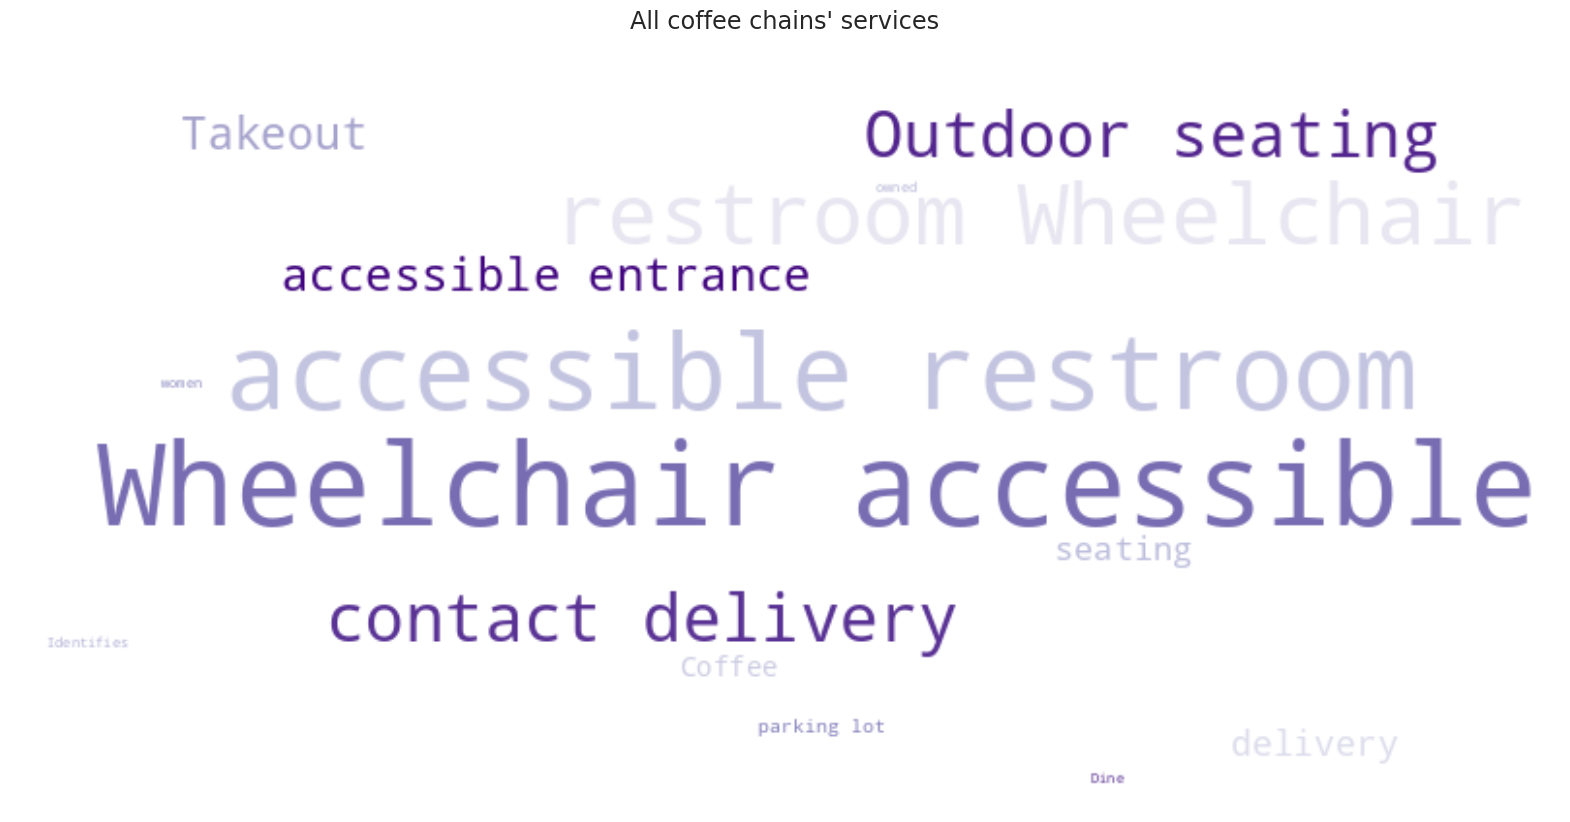

In [105]:
from wordcloud import WordCloud

text = " ".join([" ".join(df["info"]) for df in dfs.values()])
wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="Purples",
).generate(text)

plt.figure(figsize=(20, 12))
plt.imshow(wc, interpolation="bilinear")

plt.title("All coffee chains' services")
plt.axis("off")

plt.show()

**Summary:**

* Accessibility-related features (wheelchair accessible, restroom access) dominate, reflecting importance for inclusive service.
* Outdoor seating and takeaway/delivery options are prominent, highlighting convenience trends.
* Core offerings like “Coffee” appear but are less emphasized compared to service features.

### Conclusion

* Starbucks positions itself as a luxury brand: highest average ratings, more expensive, and highly concentrated in central districts with strong customer engagement.
* Phuc Long leans toward volume and accessibility: moderate-to-high review counts, wider city coverage, mid-to-large store presence, but lower average ratings.
* Highlands occupies the middle ground: reasonably priced, moderate ratings, and a balanced distribution of stores.
* Overall, accessibility, convenience (takeout/delivery), and outdoor seating are key features valued by customers across all chains.

## Problem 3

### Loading data

In [7]:
laptop_prices = pd.read_csv("../data/laptop-prices/Laptop+Prices.csv")

### Preprocessing

In [8]:
import re

def extract_processor_series(model):
    match = re.search(r"(Core i[357]|Xeon|Pentinum|Celeron|Ryzen)", model, re.IGNORECASE)
    return match.group(1) if match else "Other"

laptop_prices["CPU_series"] = laptop_prices["CPU_model"].apply(extract_processor_series)

laptop_prices.head()

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model,CPU_series
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,...,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640,Core i5
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,...,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000,Core i5
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,...,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620,Core i5
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,...,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455,Core i7
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,...,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650,Core i5


### Plots

#### Price by RAM Boxplot

**Explanation:**

Visualize the relationship between RAM and laptop price to understand how memory capacity drives cost and variability.

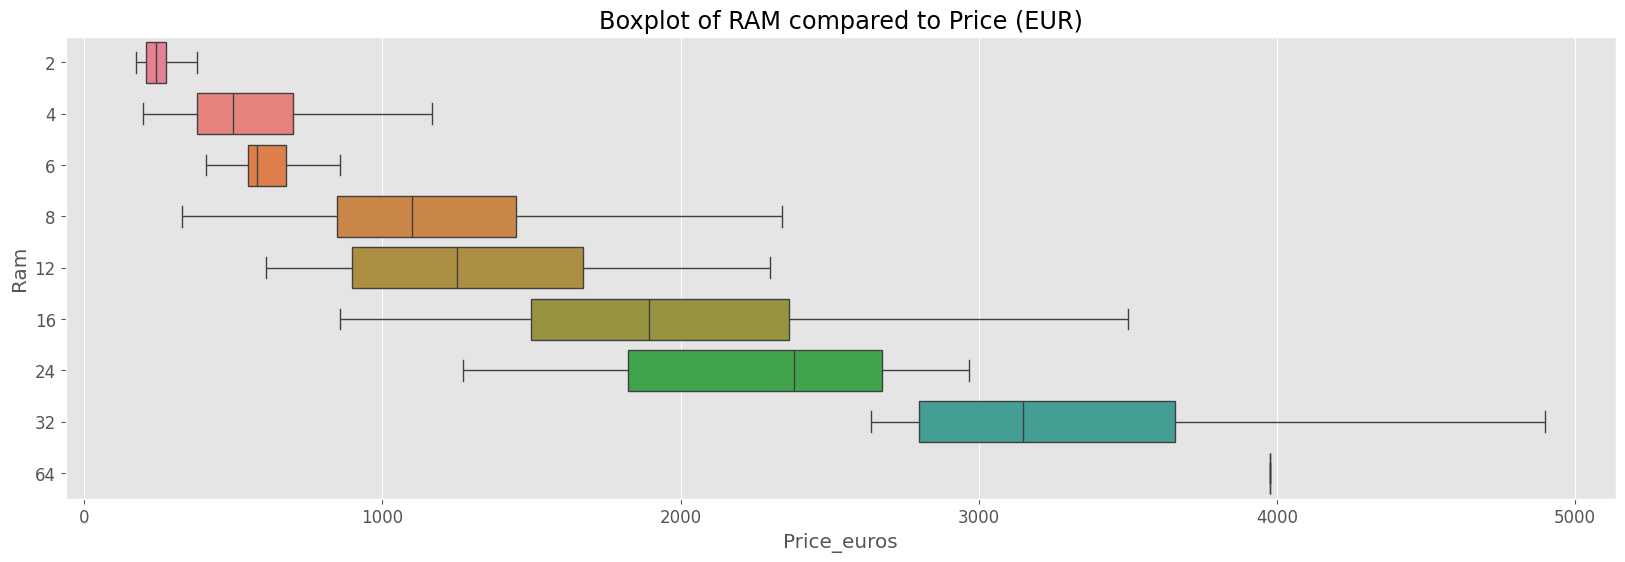

In [93]:
plt.figure(figsize=(20, 6))

sns.boxplot(
    laptop_prices,
    x="Price_euros", y="Ram", hue="Ram",
    orient="h", palette="husl", legend=False, showfliers=False,
)

plt.title("Boxplot of RAM compared to Price (EUR)")

plt.show()

**Summary:**

Laptop price rises consistently with RAM, showing strong positive correlation; Median prices increase steadily: 8 GB ~€1,300 &rarr; 32 GB ~€3,400.

* Higher RAM categories show wider price ranges, reflecting variability in features and brand.
* Low-RAM laptops (2&ndash;6 GB) remain inexpensive (< €1,000), while top-tier RAM (32&ndash;64 GB) reaches premium prices.

#### Processor Barchart

**Explanation:**

Visualize the distribution of processor types across manufacturers to understand market prevalence and trends.

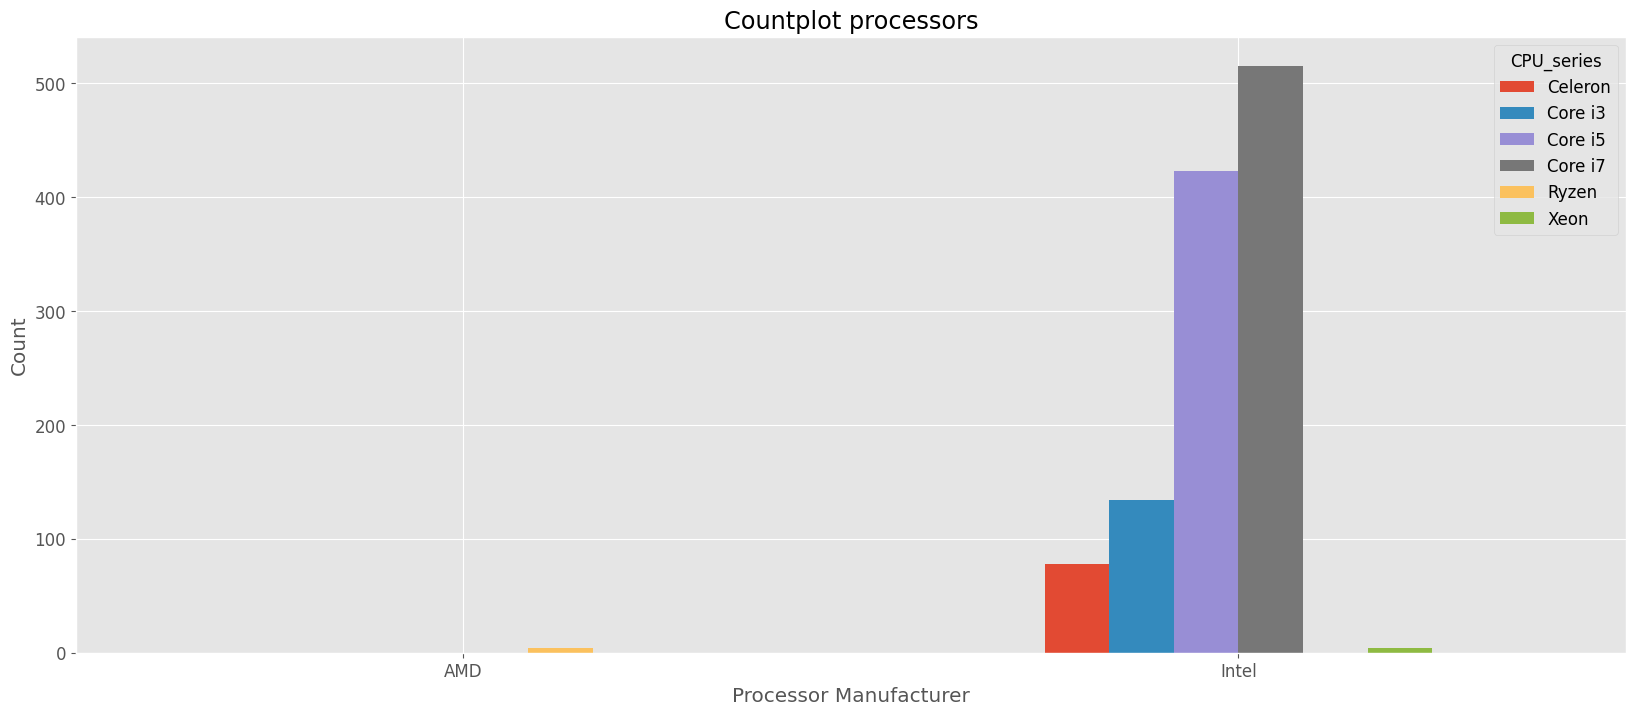

In [157]:
k_count = 10

filtered_laptops = laptop_prices[laptop_prices["CPU_series"] != "Other"]
counts = pd.crosstab(filtered_laptops["CPU_company"], filtered_laptops["CPU_series"])

counts.plot.bar(figsize=(20, 8))

plt.title("Countplot processors")

plt.xlabel("Processor Manufacturer")
plt.ylabel("Count")

plt.xticks(rotation=0)

plt.show()

**Summary:**

* Intel overwhelmingly dominates the market; AMD presence is underwhelming.
* Core i7 is the most common processor, followed by i5, i3, and Celeron.
* Xeon processors appear occasionally, mostly in workstations.
* Ryzen laptops are surprisingly rare in this dataset.

#### Price by Graphics Card Violinplot

**Explanation:**

A violin plot is used to visualize the distribution of laptop prices across the three major Graphics Card Manufacturers: Intel, AMD, and Nvidia. The plot combines a boxplot (showing median and quartiles) to show the probability density function of the price distribution for each manufacturer. This is ideal for comparing central tendencies, interquartile ranges, and the overall shape of the price data.

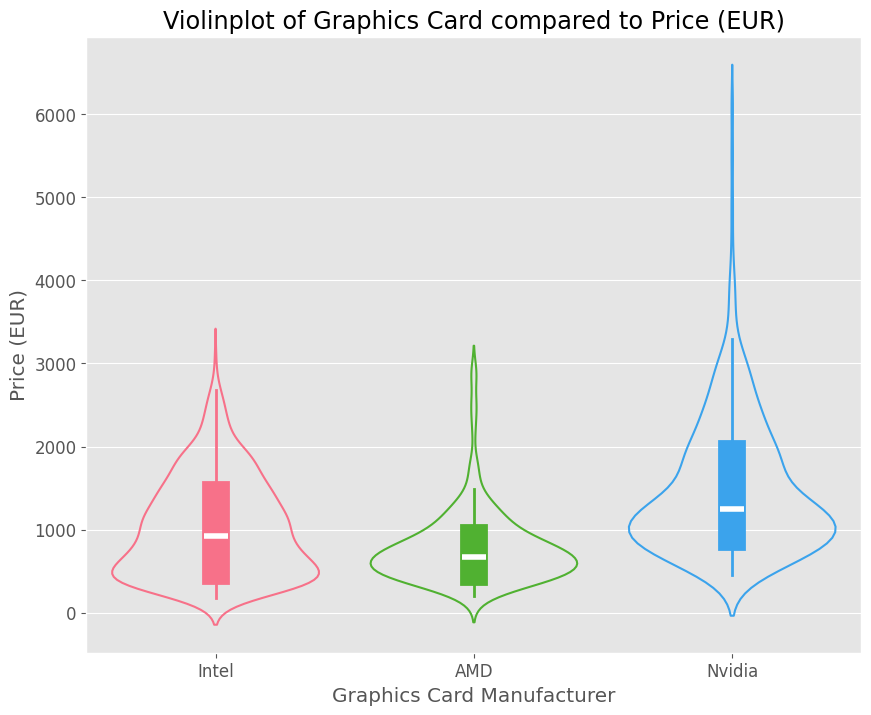

In [9]:
plt.figure(figsize=(10, 8))

sns.violinplot(
    laptop_prices[laptop_prices["GPU_company"].isin(["Intel", "AMD", "Nvidia"])],
     x="GPU_company", y="Price_euros", hue="GPU_company",
    palette="husl", legend=False, fill=False,
    inner_kws={"box_width": 20, "whis_width": 2},
)

plt.title("Violinplot of Graphics Card compared to Price (EUR)")

plt.xlabel("Graphics Card Manufacturer")
plt.ylabel("Price (EUR)")

plt.show()

**Summary:**

All graphics cards show mean of around €1,000&ndash;€1,200.

* Nvidia laptops span the widest price range (€500&ndash;6,000).
* Intel integrated GPUs tend to appear in mid-range laptops (€1,000&ndash;3,000), showing decent performance without discrete GPU.
* AMD GPUs are mostly found in slightly cheaper laptops (<€1,000), but also exceeding €3,000.

### Conclusion

Laptop pricing is strongly influenced by hardware choices:

* RAM and processors show a clear positive correlation with price.
* GPUs mainly affects the upper price range, with Nvidia catering to premium segments.
* Intel and AMD GPUs cluster around mid-range laptops.

Overall, processor performance and memory capacity remain the dominant drivers of laptop cost, confirming practical buying considerations.